# Introduction

I live in San Francisco and have grown to love it despite its (to put it nicely) bad reputation, particularly regarding crime. My friends and family who live elsewhere often ask me about how safe I feel living there, or for those who are planning to move to SF, they want to know what kinds of crime happen and which neighborhoods are the safest. **I wanted to see if I could address these questions by analyzing [SFPD Incident Reports](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data), made available by SF's [Open Data Portal](https://datasf.org/opendata/).**

## Goal
There are already several publicly available crime maps that seem to pull from the above dataset, but I felt that many of them were clumsy to use and showed information too granularily; sure, it's nice know to what exact kind of incident happened on a certain street corner in SF, but it was hard to understand:
1. A broad view of which areas of SF see the most crime
2. What kinds of crime happen, and where/when
3. Answering these questions on a per-neighborhood basis since:
    1. Each neighborhood probably has a distinct crime profile, and
    2. Neighborhoods is the way in which SF residents, or those moving into SF, talk about where to live, what things to do, and what places to explore.

So I made this [app](https://sf-city-analytics.vercel.app/) that addresses these questions! But before I got there, here is how I analyzed the data:

## About the data
See [SFPD Incident Reports Description](https://sfdigitalservices.gitbook.io/dataset-explainers/sfpd-incident-report-2018-to-present) for more info, but some notable observations:
- Each row in the dataset represents one particular incident code recorded for a given incident.
- Each incident can have multiple incident codes.
- An incident can have follow-up reports, called supplemental reports
- These are not official counts of crime. Moreover, this data is fundamentally a record of police officers reporting on various issues, meaning that this data is as much about where/when/how police officers investigate, respond to, and report on potential crimes as it is about the criminal activity itself.

## Pulling the data
The following `get_data` function pulls the incident data via API. Since my ultimate goal is to build a web app that people can use to understand the current patterns of crime in SF, **I decided to only focus on the past year of data.** I assume that over the years, different kinds of crime happen and SFPD changes how they operate, which means incident report data for prior years may not be representative of what is going on currently.

In [1]:
import time

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
from utils import get_data
start = time.time()
df = get_data(2)
print(f'Got data in {round(time.time() - start, 2)}s')

Got data in 102.29s


In [ ]:
shape = df.shape
print(f'Data has {shape[0]} rows and {shape[1]} columns')

#### top crime categories

In [7]:
df.groupby('user_friendly_category').size().sort_values()

KeyError: 'user_friendly_category'

#### hot spots for cer

## Missing data

In [4]:
df.isnull().sum() * 100 / len(df)

id                          0.000000
incident_datetime           0.000000
incident_year               0.000000
incident_day_of_week        0.000000
report_datetime             0.000000
incident_id                 0.000000
incident_number             0.000000
cad_number                 19.422818
report_type_code            0.000000
report_type_description     0.000000
filed_online               83.999727
incident_code               0.000000
incident_category           0.138844
incident_subcategory        0.138844
incident_description        0.000000
resolution                  0.000000
intersection                5.969437
cnn                         5.969437
police_district             0.000000
neighborhood                5.975400
lat                         5.969437
lon                         5.969437
dtype: float64

In [11]:
print(f'Unique values of filed_online: {list(df.filed_online.unique())}')
filed_online_percent = df[df.filed_online == True].shape[0]*100 / len(df)
print(f'Percent filed online: %{round(filed_online_percent, 2)}')

Unique values of filed_online: [None, True]
Percent filed online: %16.38


### Observations
- `id, incident_id, incident_number` are supposed to help identify each row and group them into incidents, so its good to see there's no missing data there
- 6% of data don't have location information, which means they won't be helpful when building my web app.
- 20% of the data dont have a CAD number, which comes from the system used to dispatch police officers. This number makes sense given that 16% of the data was filed online by the public and therefore wouldn't use the CAD system.
- 0.13% of reports don't have an incident category

## Exploring mutliple reports per incident
The [docs](https://sfdigitalservices.gitbook.io/dataset-explainers/sfpd-incident-report-2018-to-present#multiple-incident-codes) mention that when there are multiple reports grouped under the same incident, they will have the same `incident_id, incident_number, cad_number` values, and failure to de-duplicate these will result in double counting incidents. Let's see what this looks like.

In [12]:
# Define relevant columns to view when showing a dataframe so that they all show up
cols_to_view = [
    'report_datetime',
    'incident_datetime',
    'incident_id',
    'incident_number',
    'cad_number',
    'report_type_code',
    'incident_code',
    'incident_category',
    'incident_subcategory',
    'incident_description',
    'resolution', 'neighborhood'
]


In [13]:
# Get examples of multiple reports per incident
df.groupby(['incident_id', 'incident_number', 'cad_number']).size().sort_values(ascending=False)

incident_id  incident_number  cad_number
1334468      230786866        233073645     4
1339920      230830526        233290168     4
1299901      230513443        232041519     4
1362025      240078493        240361558     4
1298943      230512019        232032846     4
                                           ..
1331419      230761539        232971353     1
1331421      230761692        232971486     1
1331424      230762327        232972405     1
1331425      230762509        232972600     1
1401617      240397005        241773037     1
Length: 75139, dtype: int64

In [14]:
# Reports that have incident number == '230693835'
df[(df.incident_number == '230693835')][cols_to_view]

,report_datetime,incident_datetime,incident_id,incident_number,cad_number,report_type_code,incident_code,incident_category,incident_subcategory,incident_description,resolution,neighborhood
34993,2023-09-26T22:47:00.000,2023-09-22T09:00:00.000,1322870,230693835,232693740,VI,07021,Motor Vehicle Theft,Motor Vehicle Theft,"Vehicle, Stolen, Auto",Open or Active,Sunset/Parkside
34994,2023-09-26T22:47:00.000,2023-09-22T09:00:00.000,1322870,230693835,232693740,VI,05041,Burglary,Burglary - Residential,"Burglary, Residence, Forcible Entry",Open or Active,Sunset/Parkside
47089,2023-10-27T00:04:00.000,2023-10-27T00:04:00.000,1332159,230693835,233000014,VS,07041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Cite or Arrest Adult,Castro/Upper Market
47090,2023-10-27T00:04:00.000,2023-10-27T00:04:00.000,1332159,230693835,233000014,VS,63010,Warrant,Other,"Warrant Arrest, Local SF Warrant",Cite or Arrest Adult,Castro/Upper Market
47091,2023-10-27T00:04:00.000,2023-10-27T00:04:00.000,1332159,230693835,233000014,VS,71011,Other Offenses,Other Offenses,"License Plate, Found",Cite or Arrest Adult,Castro/Upper Market
47092,2023-10-27T00:04:00.000,2023-10-27T00:04:00.000,1332159,230693835,233000014,VS,11012,Stolen Property,Stolen Property,"Stolen Property, Possession with Knowledge, Re...",Cite or Arrest Adult,Castro/Upper Market


### Observations
The above table seems to decribe the following situation:
1. On 09/26/2023, a police officer was dispatched and reported both burglary and motor vehicle theft in the Sunset/Parkside neighborhood. For these 2 reports, `incident_id, cad_number` are the same, and both labeled under the `VI` report code, meaning that its for the initial report.
2. On 10/27/2023, another police officer was dispatched to the Castro/Upper Market area with an arrest warrant, and in doing so, also found a (presumably stolen) license plate and other stolen property. For these 3 reports, the `incident_id, cad_number` are different from the 09/26 reports, and their report type is `VS`, which implies that these are supplemental reports to the original 09/26 reports.
    
So it seems like there are "incidents", which describes a single instance when a police officer reports on something (and perhaps finds multiple things to report on) and "cases", which can be made up of multiple incidents that are related to each other, maybe for the same criminal investigation.

For the purposes of my web app, **I will treat all reports individually** and will not attempt to group them into cases or incidents because if I'm evaluating how safe an area of SF is, I believe an incident with multiple reports should count as a sign of more potential criminal activity than an incident with just 1 report. 

## Looking at types of incidents

In [15]:
import plotly.express as px


In [173]:
incident_counts = df.groupby('incident_category').size().sort_values()
incident_percentages = (incident_counts * 100 / len(df)).round(2)
incident_percentages = incident_percentages.reset_index().rename(columns={0:'percentage'})
fig = px.bar(incident_percentages, orientation='h', title='Incident Category %s',
             x='percentage', y='incident_category',
             labels={'percentage': '% of data', 'incident_category':'Category label'})
fig.update_layout(showlegend=False, height=1200)
fig.show()


In [46]:
misc_counts = incident_counts.loc[['Other', 'Other Offenses', 'Other Miscellaneous']].sum()
print(f'%{round(misc_counts*100 / len(df), 2)} of data with a miscellaneous-type category')

%8.54 of data with a miscellaneous-type category


### Observations
- By far the most common category is "larceny" theft, which apparently refers to the theft of physical property. To be honest, I didn't know what the word "larceny" meant exactly until this project, and I doubt its a term many people are familiar with, so I want to try to convert this term into something that is more widely understood.
- 8.5% of the data doesn't have a meaningful incident category. I want to investigate the data here more to see if there are useful categories to extract.
- The category strings are fairly clean, except for the fact that there seems to be categories `"Motor Vehical Theft", "Motor Vehicle Theft?"` that can probably be combined

Eventually, in my web app, I want to show this kind of bar chart for each neighborhood that a person is selects. In order to make it more meaningful, I'll need to do 2 things:
1. See if I can break down that "lareny" category into different and more understandable categories so that I don't need to use the word "larceny".
2. Investigate the kinds of incidents reported under `'Other', 'Other Offenses', 'Other Miscellaneous'` and see if I can extract out meaningful categories from them because ultimately, it won't be useful for someone to see that some % of incidents in a neighborhood is categorized as "other".

## Exploring larceny theft reports

### Top 10 larceny theft descriptions

In [182]:
larceny_thefts = df[df.incident_category == 'Larceny Theft']
print(f'num larceny thefts = {len(larceny_thefts)}')
counts = larceny_thefts.incident_description.value_counts()
percentages = (counts * 100 / len(larceny_thefts)).round(2).astype(str) + "%"
percentages[:10]

num larceny thefts = 30225


incident_description
Theft, From Locked Vehicle, >$950        31.91%
Theft, Other Property, $50-$200          11.16%
Theft, From Unlocked Vehicle, >$950       8.76%
Theft, Other Property, >$950              8.63%
License Plate, Stolen                      6.3%
Theft, From Locked Vehicle, $200-$950     3.97%
Theft, Shoplifting, $200-$950             2.86%
Theft, Shoplifting, >$950                 2.83%
Theft, From Building, >$950               1.99%
Theft, Shoplifting, <$50                  1.97%
Name: count, dtype: object

In [171]:
top_theft_descriptions = larceny_thefts.incident_description.str.lower().str.contains('vehicle') | \
    larceny_thefts.incident_description.str.lower().str.contains('building') | \
    larceny_thefts.incident_description.str.lower().str.contains('shoplifting') | \
    larceny_thefts.incident_description.str.lower().str.contains('license plate')
print(f'Incidents with "Vehicle", "Building", "Shoplifting", or "License plate" make up \
{round(larceny_thefts[specific_theft_descriptions].shape[0] *100 /len(larceny_thefts), 2)}% of \
larceny thefts')

Incidents with "Vehicle", "Building", "Shoplifting", or "License plate" make up 71.76% of larceny thefts


### Observations
Not surprisingly, the biggest category of theft is from a vehicle, along with theft from building or shoplifting. 

## Exploring miscellaneous incidents

In [189]:
other_categories = ['Other', 'Other Offenses', 'Other Miscellaneous']
other_thefts = df[df.incident_category.isin(other_categories)]
print(f'num "other" thefts = {len(other_thefts)}')
counts = other_thefts.incident_description.value_counts()
percentages = (counts * 100 / len(larceny_thefts)).round(2).astype(str) + "%"
percentages[:30]

num "other" thefts = 10122


incident_description
Investigative Detention                                            7.07%
Trespassing                                                        3.65%
Death Report, Cause Unknown                                        3.59%
Resisting, Delaying, or Obstructing  Peace Officer Duties           2.9%
Driving, No License Issued                                         2.28%
License Plate, Recovered                                           2.24%
Conspiracy                                                         2.05%
Evading a Police Officer Recklessly                                1.25%
Driving, License Suspended or Revoked                              0.95%
Driving While Under The Influence Of Alcohol                       0.93%
Burglary Tools, Possession Of                                      0.74%
License Plate, Found                                               0.67%
Probation Violation                                                0.48%
Death Report, Natural Causes  

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [58]:
unique_descriptions = other_thefts.incident_description.unique()
wordcloud = WordCloud(
    background_color='white',
    width=1000, height=500).generate(', '.join(unique_descriptions))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: name 'other_thefts' is not defined

In [195]:
mission = df[df.neighborhood == 'Mission']

In [198]:
mission['incident_date'] = mission.incident_datetime.dt.date

/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_65965/447907107.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [201]:
mission.groupby('incident_date').size().sort_index()

incident_date
2023-07-03    22
2023-07-04    33
2023-07-05    41
2023-07-06    24
2023-07-07    25
              ..
2024-06-28    21
2024-06-29    25
2024-06-30    30
2024-07-01    25
2024-07-02    15
Length: 366, dtype: int64

In [202]:
x = mission.groupby('incident_date').size().sort_index()

In [207]:
from datetime import datetime
from dateutil.relativedelta import relativedelta


In [208]:
today = datetime.today()
cutoff_date = today - relativedelta(years=1)

In [210]:
import pandas as pd

In [211]:
date_range = pd.date_range(start=cutoff_date, end=today-relativedelta(days=1))

In [215]:
date_range[0].date()

datetime.date(2023, 7, 3)

In [216]:
x.loc[date_range[0].date()]

22

In [218]:
mission.groupby('incident_date').size().sum() / 365

32.66027397260274

In [219]:
tenderloin = df[df.neighborhood == 'Tenderloin']
tenderloin.shape

(14130, 22)

In [220]:
t_mvt = tenderloin[tenderloin.incident_category == 'Motor Vehicle Theft']
m_mvt = mission[mission.incident_category == 'Motor Vehicle Theft']

In [222]:
t_mvt.shape, m_mvt.shape

((406, 22), (903, 23))

In [223]:
df.neighborhood.unique()

array(['Bayview Hunters Point', 'Western Addition', 'Presidio',
       'North Beach', 'Potrero Hill', 'Hayes Valley', 'Mission',
       'Nob Hill', 'Inner Sunset', 'Marina', 'Sunset/Parkside',
       'Oceanview/Merced/Ingleside', None, 'South of Market',
       'Lone Mountain/USF', 'Tenderloin', 'Outer Richmond',
       'Financial District/South Beach', 'Mission Bay',
       'West of Twin Peaks', 'Inner Richmond', 'Outer Mission',
       'Russian Hill', 'Chinatown', 'Lakeshore', 'Castro/Upper Market',
       'Excelsior', 'Portola', 'Bernal Heights', 'Japantown',
       'Noe Valley', 'Golden Gate Park', 'Lincoln Park',
       'Pacific Heights', 'Twin Peaks', 'Visitacion Valley', 'Glen Park',
       'Haight Ashbury', 'Presidio Heights', 'Treasure Island',
       'Seacliff', 'McLaren Park', 'null'], dtype=object)

In [226]:
district_pop = pd.Series({
  "Bayview Hunters Point": 38480.0,
  "Bernal Heights": 26149.0,
  "Castro/Upper Market": 23138.0,
  "Chinatown": 14310.0,
  "Excelsior": 40980.0,
  "Financial District/South Beach": 22963.0,
  "Glen Park": 8654.0,
  "Golden Gate Park": 32.0,
  "Haight Ashbury": 19181.0,
  "Hayes Valley": 19818.0,
  "Inner Richmond": 22753.0,
  "Inner Sunset": 28551.0,
  "Japantown": 3624.0,
  "Lakeshore": 14368.0,
  "Lincoln Park": 185.0,
  "Lone Mountain/USF": 17350.0,
  "Marina": 25186.0,
  "McLaren Park": 153.0,
  "Mission": 58424.0,
  "Mission Bay": 13330.0,
  "Nob Hill": 26247.0,
  "Noe Valley": 22628.0,
  "North Beach": 11934.0,
  "Oceanview/Merced/Ingleside": 27335.0,
  "Outer Mission": 24646.0,
  "Outer Richmond": 45745.0,
  "Pacific Heights": 23953.0,
  "Portola": 16243.0,
  "Potrero Hill": 14845.0,
  "Presidio": 4073.0,
  "Presidio Heights": 10445.0,
  "Russian Hill": 18237.0,
  "Seacliff": 2416.0,
  "South of Market": 25132.0,
  "Sunset/Parkside": 81639.0,
  "Tenderloin": 29726.0,
  "Treasure Island": 3184.0,
  "Twin Peaks": 8068.0,
  "Visitacion Valley": 19875.0,
  "West of Twin Peaks": 38485.0,
  "Western Addition": 22299.0,
})

In [227]:
district_pop

Bayview Hunters Point             38480.0
Bernal Heights                    26149.0
Castro/Upper Market               23138.0
Chinatown                         14310.0
Excelsior                         40980.0
Financial District/South Beach    22963.0
Glen Park                          8654.0
Golden Gate Park                     32.0
Haight Ashbury                    19181.0
Hayes Valley                      19818.0
Inner Richmond                    22753.0
Inner Sunset                      28551.0
Japantown                          3624.0
Lakeshore                         14368.0
Lincoln Park                        185.0
Lone Mountain/USF                 17350.0
Marina                            25186.0
McLaren Park                        153.0
Mission                           58424.0
Mission Bay                       13330.0
Nob Hill                          26247.0
Noe Valley                        22628.0
North Beach                       11934.0
Oceanview/Merced/Ingleside        

In [231]:
(df.groupby('neighborhood').size() / district_pop).sort_values(ascending=False)

Golden Gate Park                  37.187500
McLaren Park                       1.117647
Lincoln Park                       1.032432
Tenderloin                         0.475341
South of Market                    0.373747
Financial District/South Beach     0.297174
North Beach                        0.273169
Japantown                          0.255795
Mission                            0.204043
Bayview Hunters Point              0.196700
Western Addition                   0.174044
Hayes Valley                       0.146786
Chinatown                          0.145213
Russian Hill                       0.127817
Mission Bay                        0.126182
Treasure Island                    0.124686
Nob Hill                           0.122604
Castro/Upper Market                0.115827
Marina                             0.113079
Lakeshore                          0.112333
Potrero Hill                       0.109330
Bernal Heights                     0.094956
Portola                         

## Forecasting

In [105]:
m = df[df.neighborhood == 'Mission']
m['incident_date'] = df.incident_datetime.dt.date
m.groupby('incident_date').size()

/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_56440/1221172882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m['incident_date'] = df.incident_datetime.dt.date


incident_date
2022-07-10    21
2022-07-11    36
2022-07-12    30
2022-07-13    31
2022-07-14    36
              ..
2024-07-05    32
2024-07-06    37
2024-07-07    30
2024-07-08    29
2024-07-09    13
Length: 731, dtype: int64

In [106]:
m.groupby('incident_date').size()

incident_date
2022-07-10    21
2022-07-11    36
2022-07-12    30
2022-07-13    31
2022-07-14    36
              ..
2024-07-05    32
2024-07-06    37
2024-07-07    30
2024-07-08    29
2024-07-09    13
Length: 731, dtype: int64

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

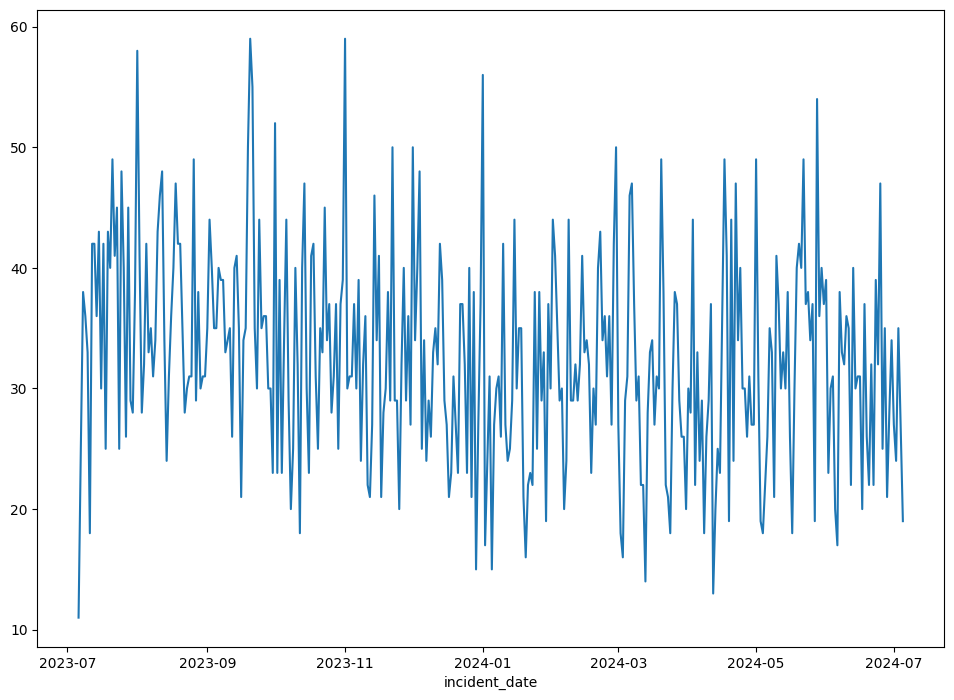

In [11]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(data=m.groupby('incident_date').size(), ax=ax);

In [12]:
df['incident_date'] = df.incident_datetime.dt.date

In [13]:
top_neighborhoods = [
    'Tenderloin', 'South of Market', 'Mission', 'Financial District/South Beach', 'Bayview Hunters Point'
    #'Sunset/Parkside', 'Western Addition', 'Nob Hill'#, 'Hayes Valley', 'Outer Richmond', 'Castro/Upper Market',
    #'West of Twin Peaks', 'Marina'
]

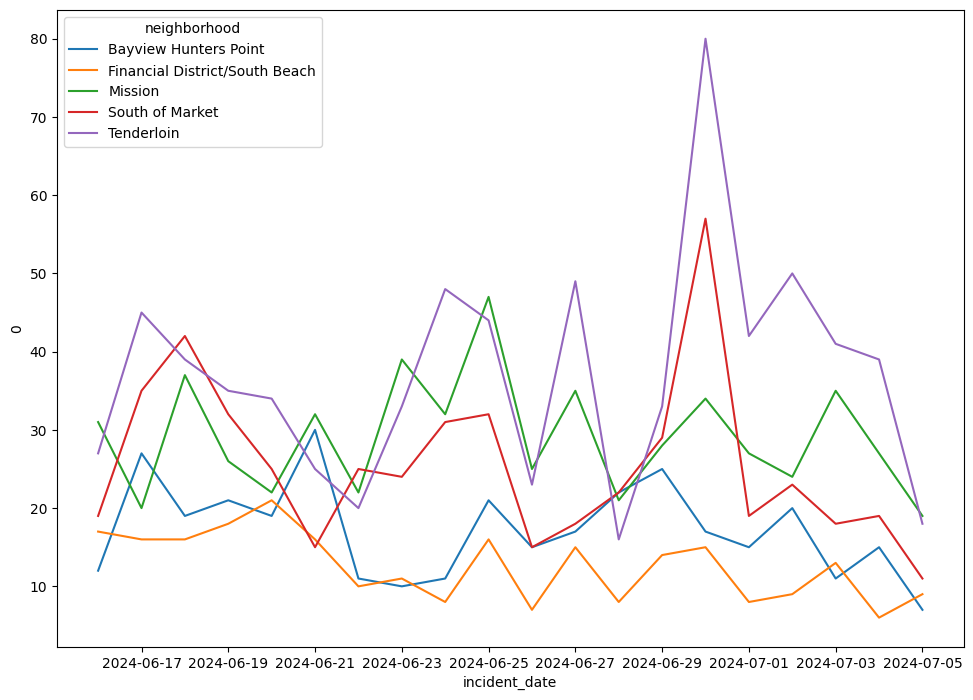

In [14]:
x = df[df.neighborhood.isin(top_neighborhoods)]
y = x.groupby(['incident_date', 'neighborhood']).size().reset_index().iloc[-100:]
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(data=y, x='incident_date', y=0, hue='neighborhood', ax=ax);

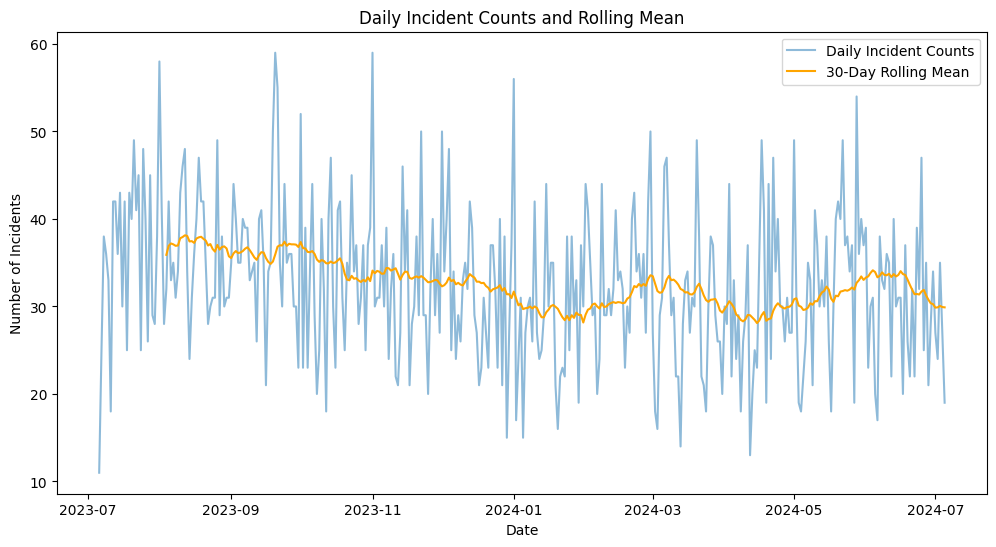

In [15]:
x = m.groupby('incident_date').size()
window_size = 30  # for example, a 7-day rolling mean
rolling_mean = x.rolling(window=window_size).mean()
plt.figure(figsize=(12, 6))
plt.plot(x, label='Daily Incident Counts', alpha=0.5)
plt.plot(rolling_mean, label=f'{window_size}-Day Rolling Mean', color='orange')
plt.title('Daily Incident Counts and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

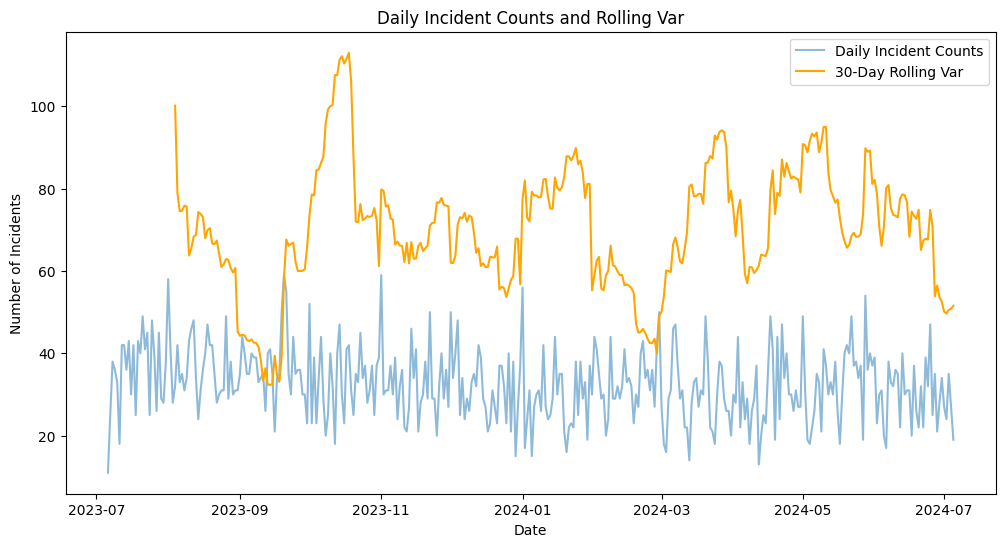

In [16]:
x = m.groupby('incident_date').size()
window_size = 30  # for example, a 7-day rolling mean
rolling_mean = x.rolling(window=window_size).var()
plt.figure(figsize=(12, 6))
plt.plot(x, label='Daily Incident Counts', alpha=0.5)
plt.plot(rolling_mean, label=f'{window_size}-Day Rolling Var', color='orange')
plt.title('Daily Incident Counts and Rolling Var')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

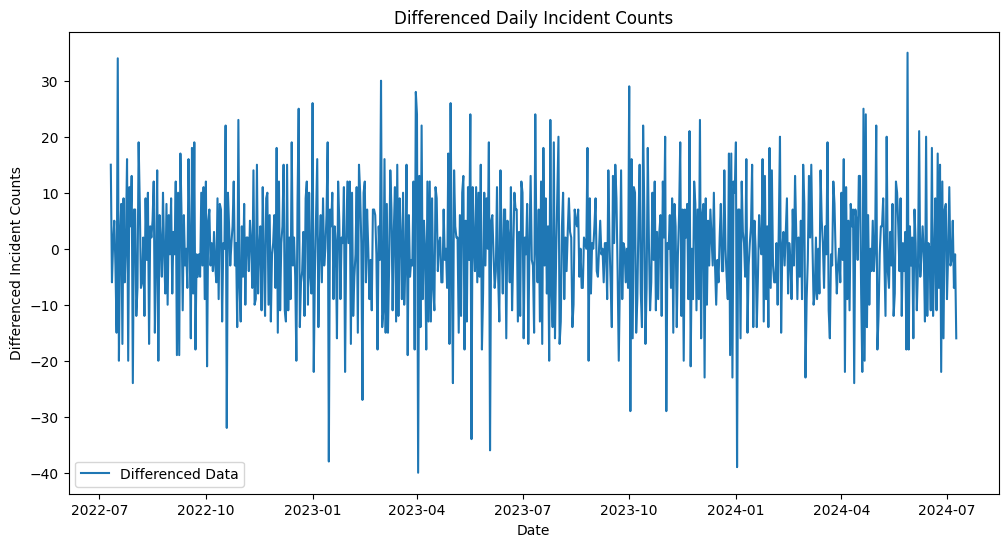

NameError: name 'adfuller' is not defined

In [107]:
x = m.groupby('incident_date').size()
differenced_data = x.diff().dropna()
# Step 6: Check for stationarity
# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(differenced_data, label='Differenced Data')
plt.title('Differenced Daily Incident Counts')
plt.xlabel('Date')
plt.ylabel('Differenced Incident Counts')
plt.legend()
plt.show()

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(differenced_data)
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

In [19]:
adf_test = adfuller(x.diff().dropna())
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print("Number of lags:", adf_test[2])
print("Number of observations:", adf_test[3])
print("Critical Values:", adf_test[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Statistic: -9.21930019503605
p-value: 1.7979978580926716e-15
Number of lags: 12
Number of observations: 352
Critical Values: {'1%': -3.4490648539347544, '5%': -2.8697861692116478, '10%': -2.5711631253228306}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [20]:
adf_test = adfuller(x)
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print("Number of lags:", adf_test[2])
print("Number of observations:", adf_test[3])
print("Critical Values:", adf_test[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Statistic: -4.346021945189333
p-value: 0.00036939303883169955
Number of lags: 8
Number of observations: 357
Critical Values: {'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [21]:
from statsmodels.graphics.tsaplots import plot_acf


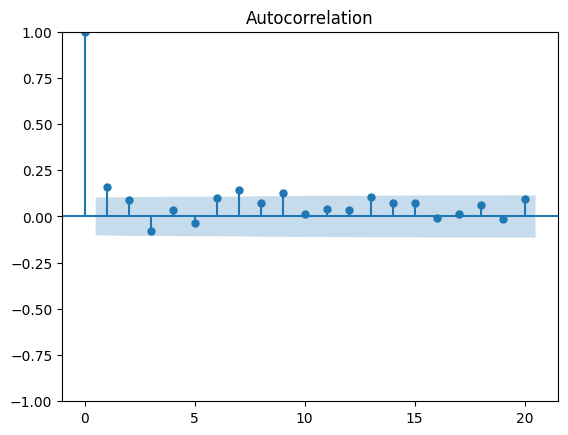

In [23]:
plot_acf(x, lags=20);


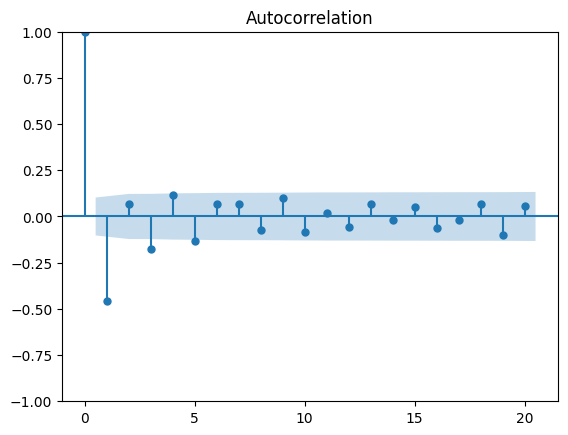

In [24]:
plot_acf(x.diff().dropna(), lags=20);


<Axes: ylabel='Frequency'>

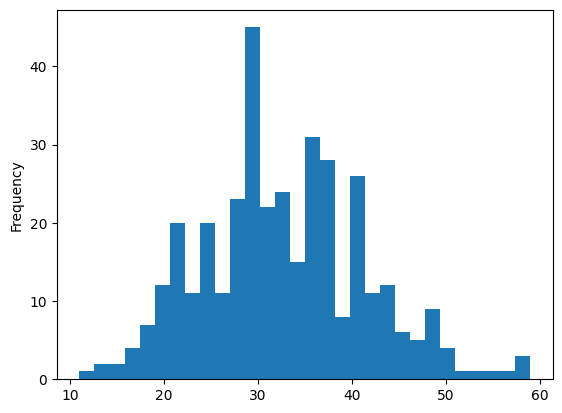

In [26]:
x.plot.hist(bins=30)

In [32]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

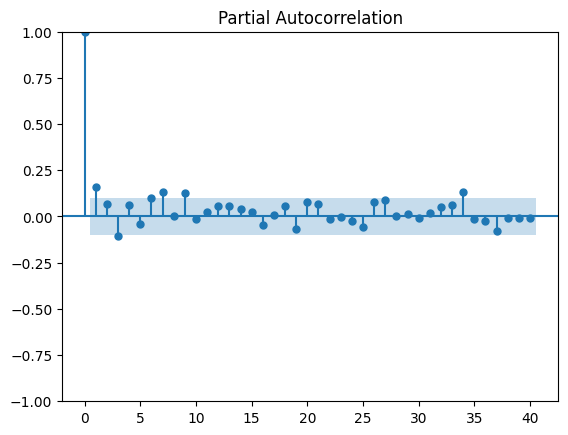

In [35]:
plot_pacf(x, lags=40);

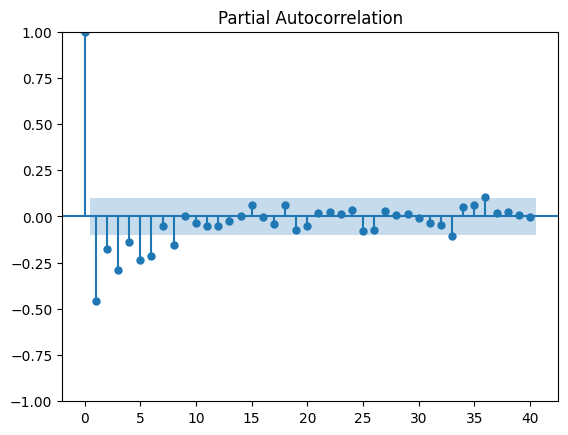

In [143]:
plot_pacf(x.diff().dropna(), lags=40);

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [47]:
import pandas as pd

In [48]:
x.index = pd.to_datetime(x.index)

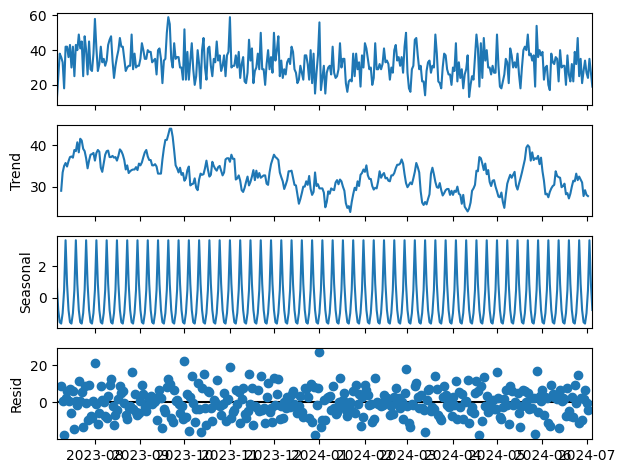

In [51]:
decomposed = seasonal_decompose(x)
decomposed.plot();

In [61]:
from statsmodels.tsa.ar_model import AutoReg as AR

In [68]:
import numpy as np

In [103]:
def train_test_split(df, num_test=None):
    n = len(df)
    if num_test is None:
        test_n = n // 4
    else:
        test_n = num_test
    return df.iloc[:-test_n], df.iloc[-test_n:]
    

def train_and_plot(df):
    df = df.reset_index()
    df_train, df_test = train_test_split(df)
    
    # AR model
    lag = 5
    model = AR(df_train[0], lags=lag).fit()
    forecasts = model.predict(
        start=len(df_train),
        end=len(df_train) + len(df_test) - 1,
        dynamic=False
    )
    

    plt.figure(figsize=(12, 6))
    plt.plot(df_train[0], label='Training data')
    plt.plot(df_test[0], color='gray', label='Testing data')
    plt.plot(forecasts, color='orange', label='Forecasts')
    plt.legend();

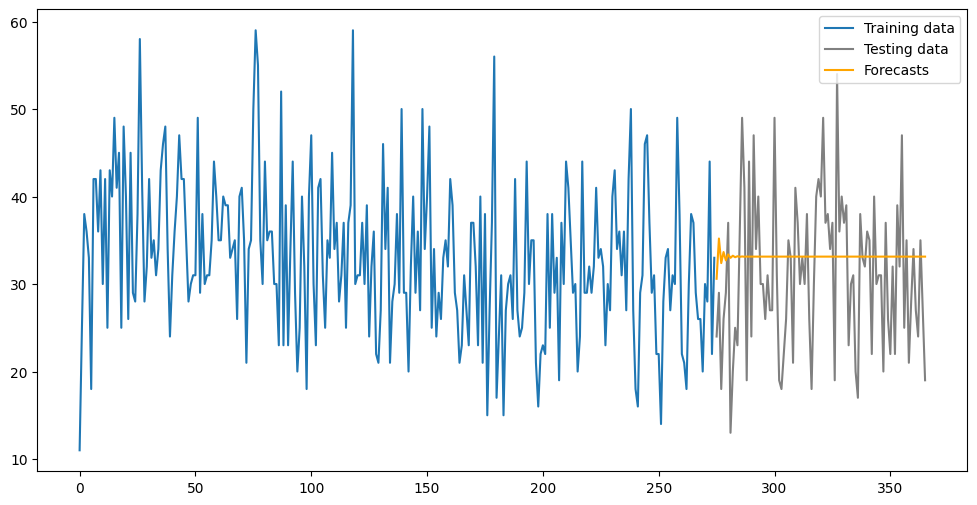

In [82]:
train_and_plot(x)

In [83]:
x.ewm(span=6, adjust=False).mean()

incident_date
2023-07-06    11.000000
2023-07-07    15.000000
2023-07-08    21.571429
2023-07-09    25.693878
2023-07-10    27.781341
                ...    
2024-07-01    29.551914
2024-07-02    27.965653
2024-07-03    29.975466
2024-07-04    29.125333
2024-07-05    26.232381
Length: 366, dtype: float64

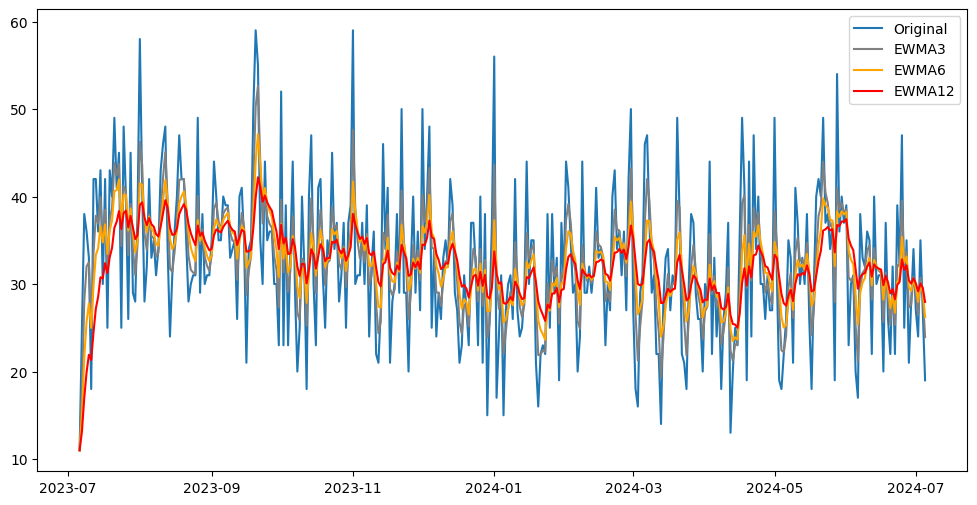

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(x, label='Original')
plt.plot(x.ewm(span=3, adjust=False).mean(), color='gray', label='EWMA3')
plt.plot(x.ewm(span=6, adjust=False).mean(), color='orange', label='EWMA6')
plt.plot(x.ewm(span=12, adjust=False).mean(), color='red', label='EWMA12')
plt.legend();

In [85]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


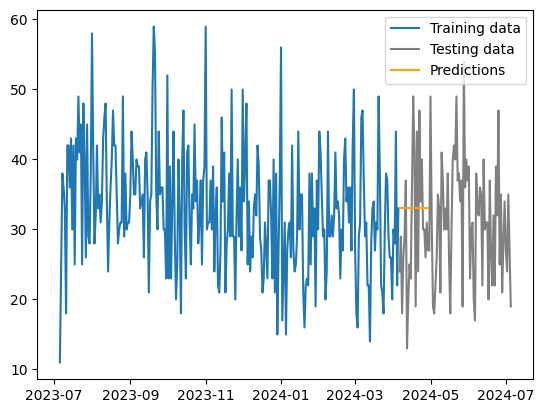

In [90]:
df_train, df_test = train_test_split(x)

span = 1 
alpha = 2 / (span + 1)
model = SimpleExpSmoothing(df_train)
results = model.fit(smoothing_level=alpha, optimized=False)
predictions = results.forecast(steps=24)

# Plot
plt.plot(df_train, label='Training data')
plt.plot(df_test, color='gray', label='Testing data')
plt.plot(predictions, color='orange', label='Predictions')
plt.legend();

In [95]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error


/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib

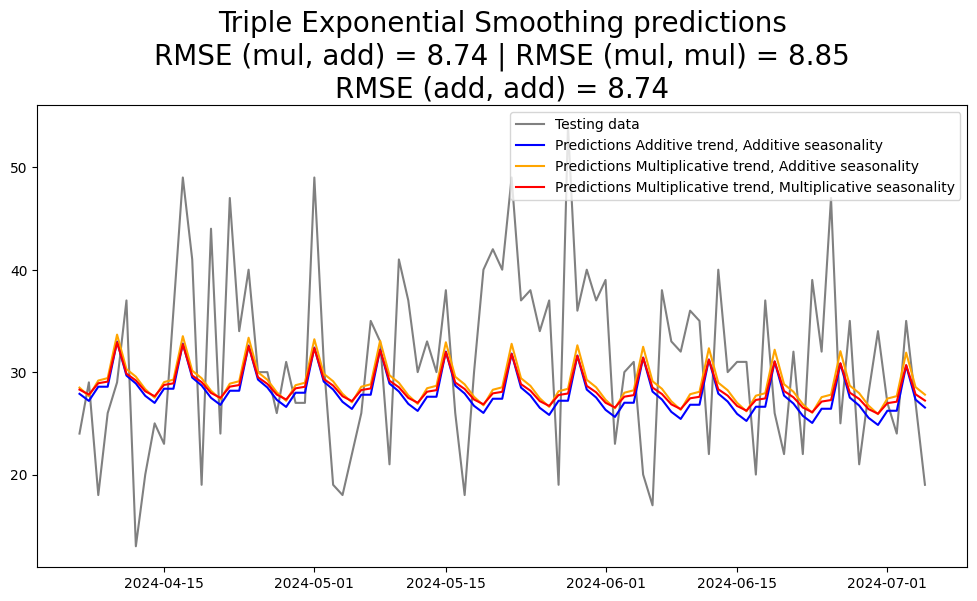

In [114]:
plt.figure(figsize=(12, 6))
forecast_n = 91

df_train, df_test = train_test_split(x)
seasonal_period = 7
# Multiplicative trend / Additive seasonality model
model_add_add = ExponentialSmoothing(df_train, trend='add', seasonal='add', seasonal_periods=seasonal_period)
results_add_add = model_add_add.fit()
predictions_add_add = results_add_add.forecast(steps=forecast_n)

# Multiplicative trend / Additive seasonality model
model_mul_add = ExponentialSmoothing(df_train, trend='mul', seasonal='add', seasonal_periods=seasonal_period)
results_mul_add = model_mul_add.fit()
predictions_mul_add = results_mul_add.forecast(steps=forecast_n)

# Multiplicative trend / Multiplicative seasonality model
model_mul_mul = ExponentialSmoothing(df_train, trend='mul', seasonal='mul', seasonal_periods=seasonal_period)
results_mul_mul = model_mul_mul.fit()
predictions_mul_mul = results_mul_mul.forecast(steps=forecast_n)

# Evaluate
rmse_add_add = mean_squared_error(df_test, predictions_add_add, squared=False)
rmse_mul_add = mean_squared_error(df_test, predictions_mul_add, squared=False)
rmse_mul_mul = mean_squared_error(df_test, predictions_mul_mul, squared=False)

# Plot
plt.title(f'Triple Exponential Smoothing predictions\nRMSE (mul, add) = {np.round(rmse_mul_add, 2)} | RMSE (mul, mul) = {np.round(rmse_mul_mul, 2)}\nRMSE (add, add) = {np.round(rmse_mul_add, 2)}', size=20)
plt.plot(df_test, color='gray', label='Testing data')
plt.plot(predictions_add_add, color='blue', label='Predictions Additive trend, Additive seasonality')
plt.plot(predictions_mul_add, color='orange', label='Predictions Multiplicative trend, Additive seasonality')
plt.plot(predictions_mul_mul, color='red', label='Predictions Multiplicative trend, Multiplicative seasonality')
plt.legend();

In [92]:
from statsmodels.tsa.arima.model import ARIMA

In [93]:
from sklearn.metrics import mean_absolute_percentage_error as mape

/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


rmse=8.24229226223673, mape_val=0.276771061798114


/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


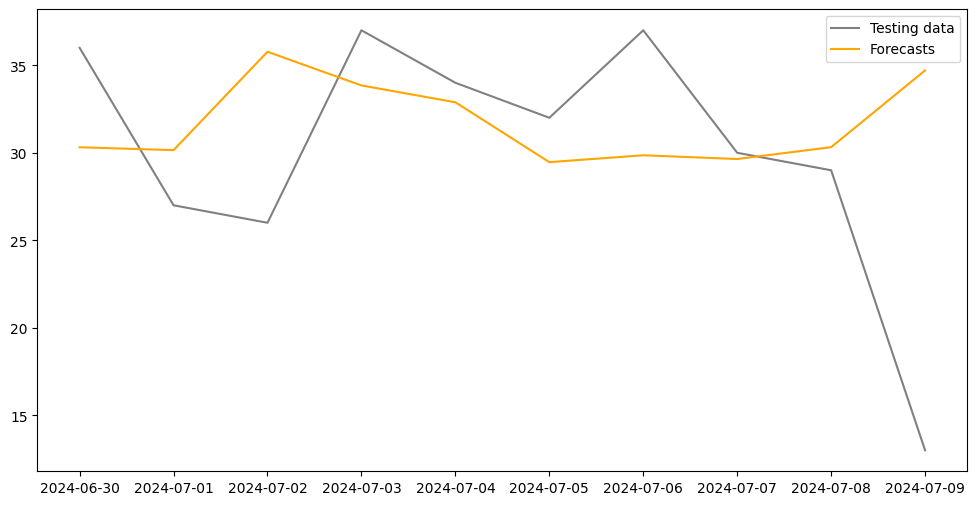

In [108]:
df_train, df_test = train_test_split(x, num_test=10)
    
# AR model
lag = 5
model = ARIMA(df_train, seasonal_order=(0, 1, 6, 7)).fit()
forecasts = model.predict(
    start=len(df_train),
    end=len(df_train) + len(df_test) - 1,
    dynamic=False
)

rmse = mean_squared_error(df_test, forecasts, squared=False)
mape_val = mape(df_test, forecasts)
print(f'rmse={rmse}, mape_val={mape_val}')
plt.figure(figsize=(12, 6))
plt.plot(df_test, color='gray', label='Testing data')
plt.plot(forecasts, color='orange', label='Forecasts')
plt.legend();

/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


rmse=1.1583923404895462, mape_val=1.938870303793637


/opt/homebrew/Caskroom/miniconda/base/envs/sf_incidents_2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


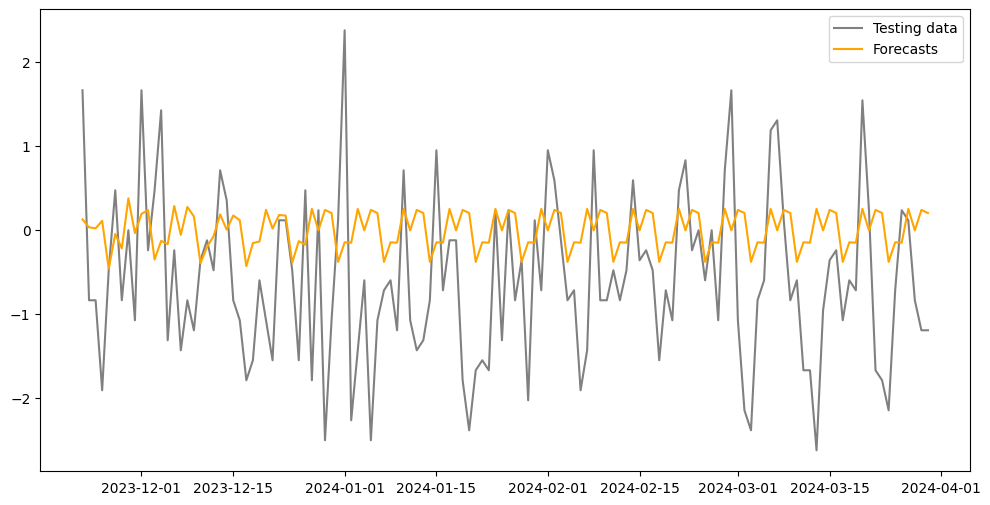

In [100]:
    # AR model
lag = 5
model = ARIMA(scaled_train, seasonal_order=(0, 1, 6, 7)).fit()
forecasts = model.predict(
    start=len(scaled_train),
    end=len(scaled_train) + len(scaled_val) - 1,
    dynamic=False
)

rmse = mean_squared_error(scaled_val, forecasts, squared=False)
mape_val = mape(scaled_val, forecasts)
print(f'rmse={rmse}, mape_val={mape_val}')
plt.figure(figsize=(12, 6))
plt.plot(scaled_val, color='gray', label='Testing data')
plt.plot(forecasts, color='orange', label='Forecasts')
plt.legend();

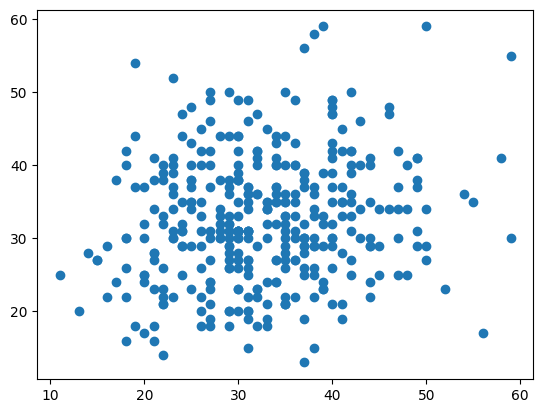

In [145]:
plt.scatter(x.iloc[:-1], x.iloc[1:])

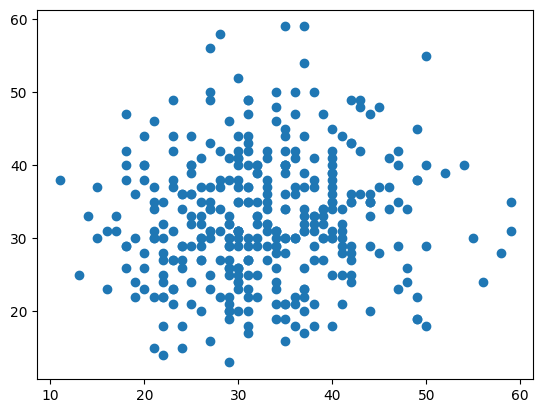

In [146]:
plt.scatter(x.iloc[:-2], x.iloc[2:])

# LSTM

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd

In [64]:
m = df[df.neighborhood == 'Mission']
m['incident_date'] = df.incident_datetime.dt.date
data = m.groupby('incident_date').size().to_frame().rename(columns={0: 'incident_count'})
data.head()

/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_56440/169061239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m['incident_date'] = df.incident_datetime.dt.date


,incident_count
incident_date,
2022-07-10,21
2022-07-11,36
2022-07-12,30
2022-07-13,31
2022-07-14,36


In [65]:
train_len = 500
val_len = 130
train_df = data.iloc[:train_len]
val_df = data.iloc[train_len:(train_len+val_len)]
test_df = data.iloc[(train_len+val_len):]
train_mean, train_std = train_df.incident_count.mean(), train_df.incident_count.std()
print(f'train mean = {train_mean}, std = {train_std}')
scaled_train = (train_df - train_mean ) / train_std
scaled_val = (val_df - train_mean) / train_std
scaled_test = (test_df - train_mean) / train_std

train mean = 36.05, std = 8.40146828469152


In [66]:
scaled_train.shape, scaled_val.shape, scaled_test.shape

((500, 1), (130, 1), (101, 1))

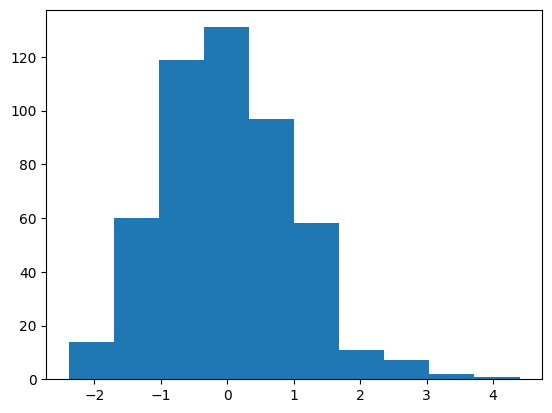

In [67]:
plt.hist(scaled_train.incident_count);

In [68]:
import tensorflow as tf

In [112]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=scaled_train, val_df=scaled_val, test_df=scaled_test,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        self.example = None

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='incident_count', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

In [113]:
w = WindowGenerator(input_width=60, label_width=7, shift=7, train_df=train_df, val_df=val_df,
                    test_df=test_df,label_columns=['incident_count'])
w

Total window size: 67
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60 61 62 63 64 65 66]
Label column name(s): ['incident_count']

In [116]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[70:70+w.total_window_size]),
                           np.array(train_df[140:140+w.total_window_size])])

example_inputs, example_labels = w.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 67, 1)
Inputs shape: (3, 60, 1)
Labels shape: (3, 7, 1)


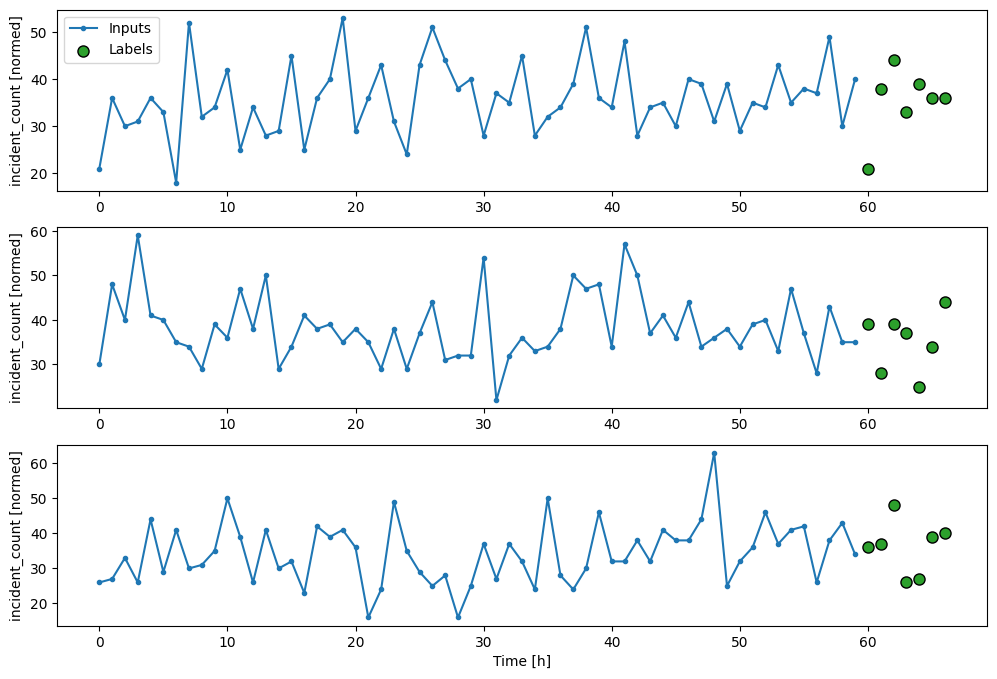

In [117]:
w.example = example_inputs, example_labels
w.plot()

In [118]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [119]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [120]:
w.train.element_spec

(TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 7, 1), dtype=tf.float32, name=None))

In [121]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 60, 1)
Labels shape (batch, time, features): (32, 7, 1)


2024-07-11 10:24:46.339678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135.4702 - mean_absolute_error: 9.4077 - mean_absolute_percentage_error: 33.2010 


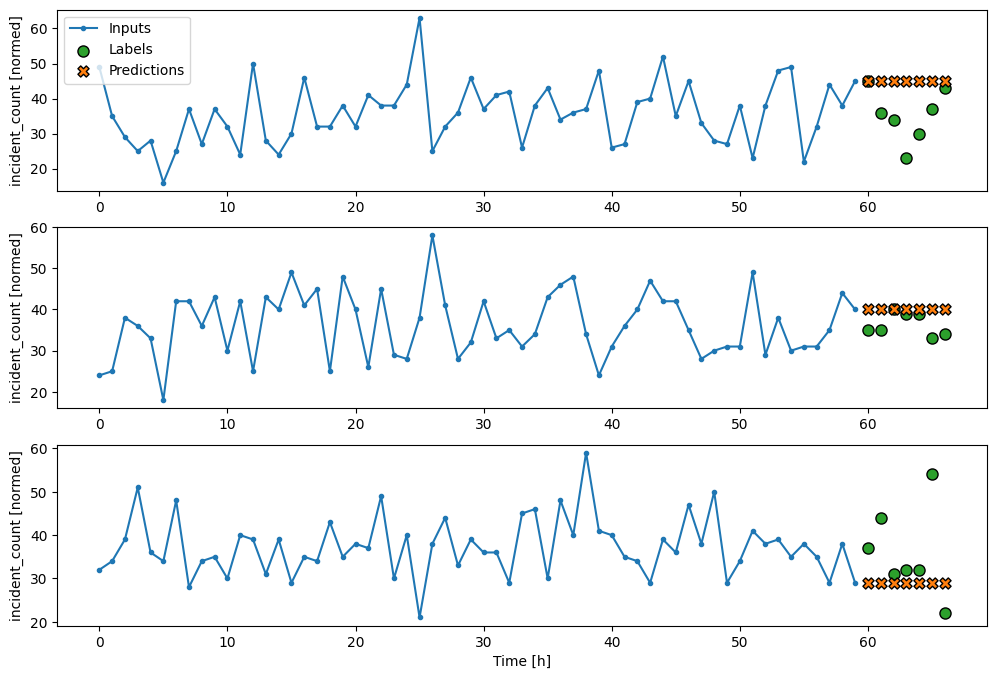

In [123]:
OUT_STEPS = 7
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError(),
                               tf.keras.metrics.MeanAbsolutePercentageError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(w.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(w.test, verbose=0, return_dict=True)
w.plot(last_baseline)

In [124]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                        tf.keras.metrics.MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [125]:
import IPython
import IPython.display

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 611.2422 - mean_absolute_error: 23.2347 - mean_absolute_percentage_error: 71.6473 


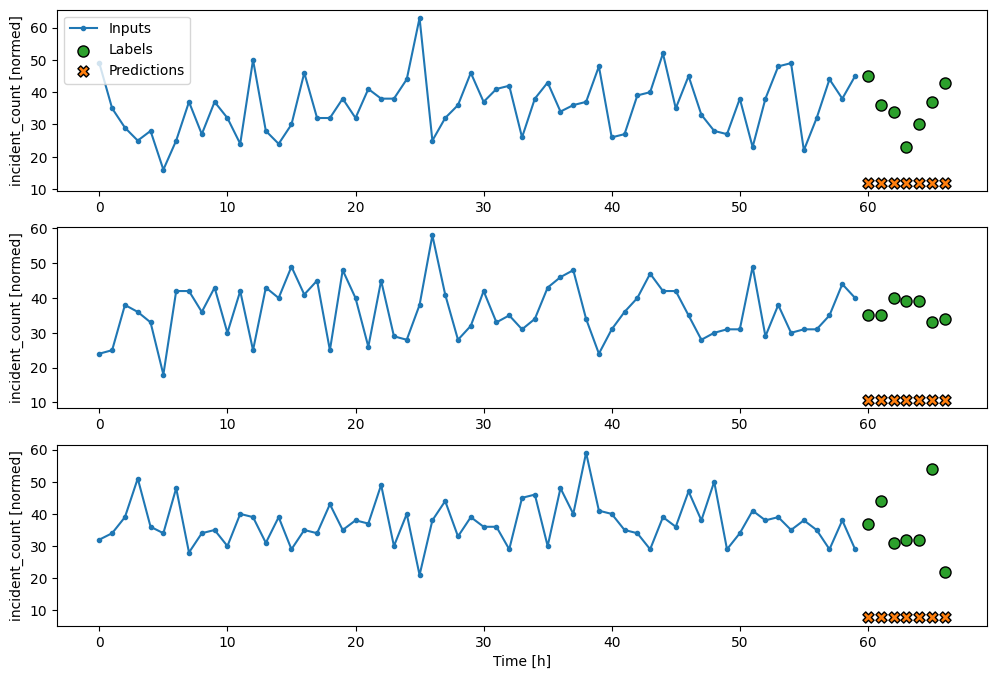

In [126]:
num_features = 1
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, w)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(w.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(w.test, verbose=0, return_dict=True)
w.plot(multi_linear_model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139.8867 - mean_absolute_error: 9.5260 - mean_absolute_percentage_error: 33.5196  


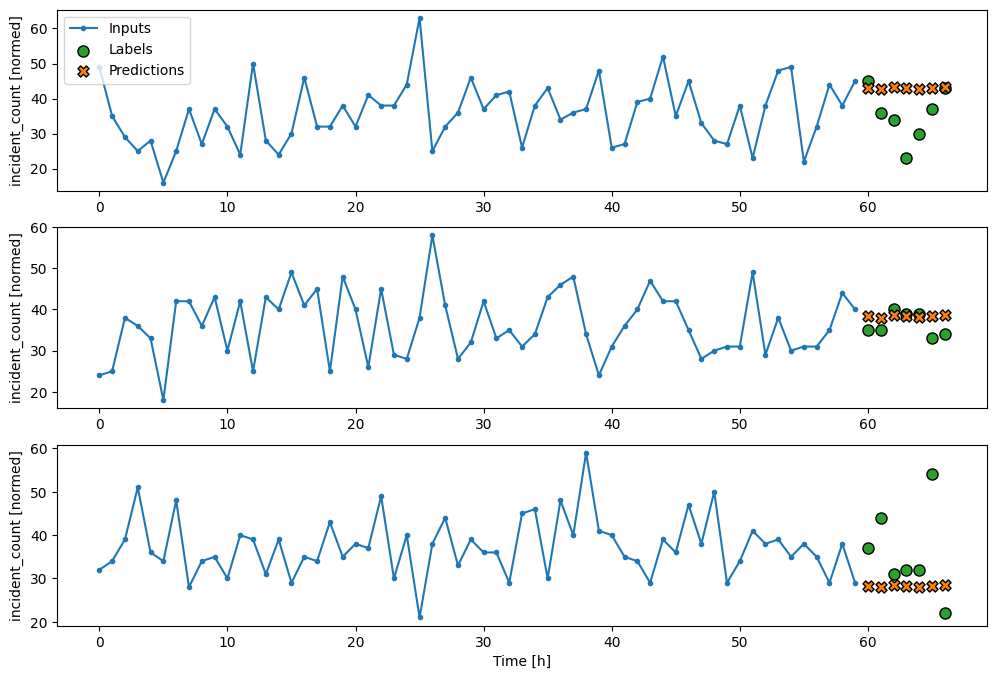

In [127]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, w)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(w.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(w.test, verbose=0, return_dict=True)
w.plot(multi_dense_model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100.0481 - mean_absolute_error: 7.9585 - mean_absolute_percentage_error: 28.2058


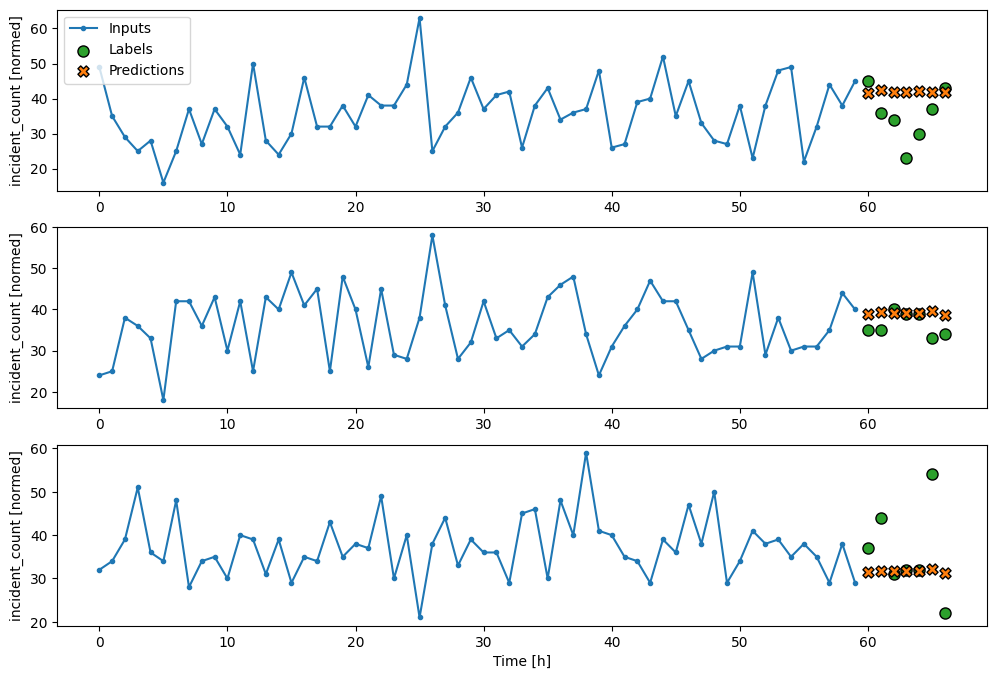

In [128]:

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, w)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(w.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(w.test, verbose=0, return_dict=True)
w.plot(multi_conv_model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 508.3979 - mean_absolute_error: 21.0700 - mean_absolute_percentage_error: 64.4299 


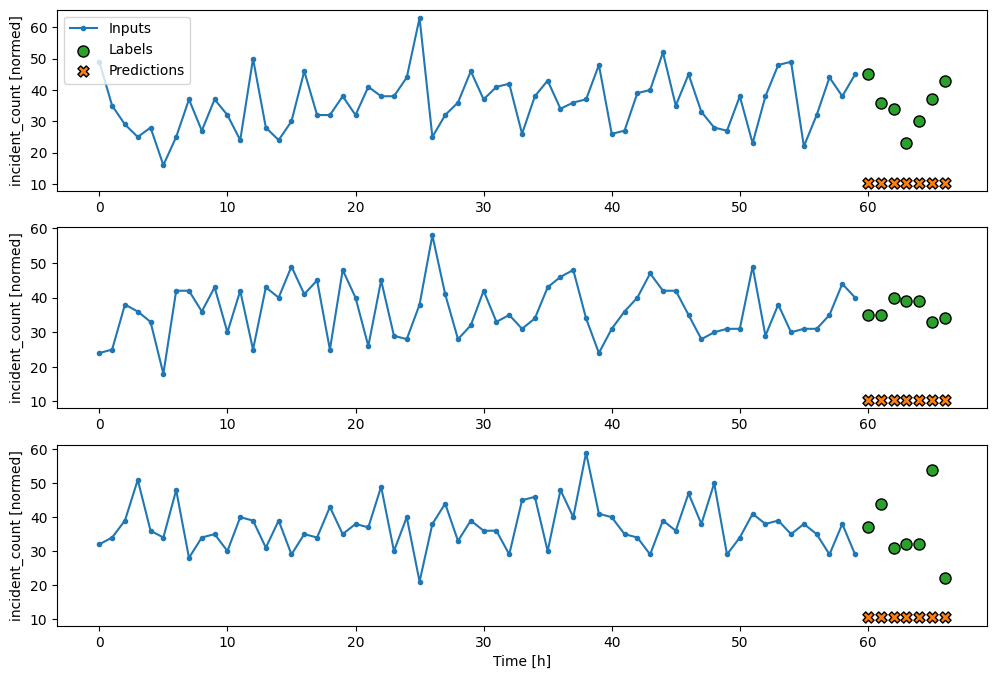

In [129]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, w)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(w.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(w.test, verbose=0, return_dict=True)
w.plot(multi_lstm_model)

In [130]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [131]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [132]:
prediction, state = feedback_model.warmup(w.example[0])
prediction.shape

TensorShape([32, 1])

In [133]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [134]:
print('Output shape (batch, time, features): ', feedback_model(w.example[0]).shape)

Output shape (batch, time, features):  (32, 7, 1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 360.8584 - mean_absolute_error: 17.1917 - mean_absolute_percentage_error: 50.9494 


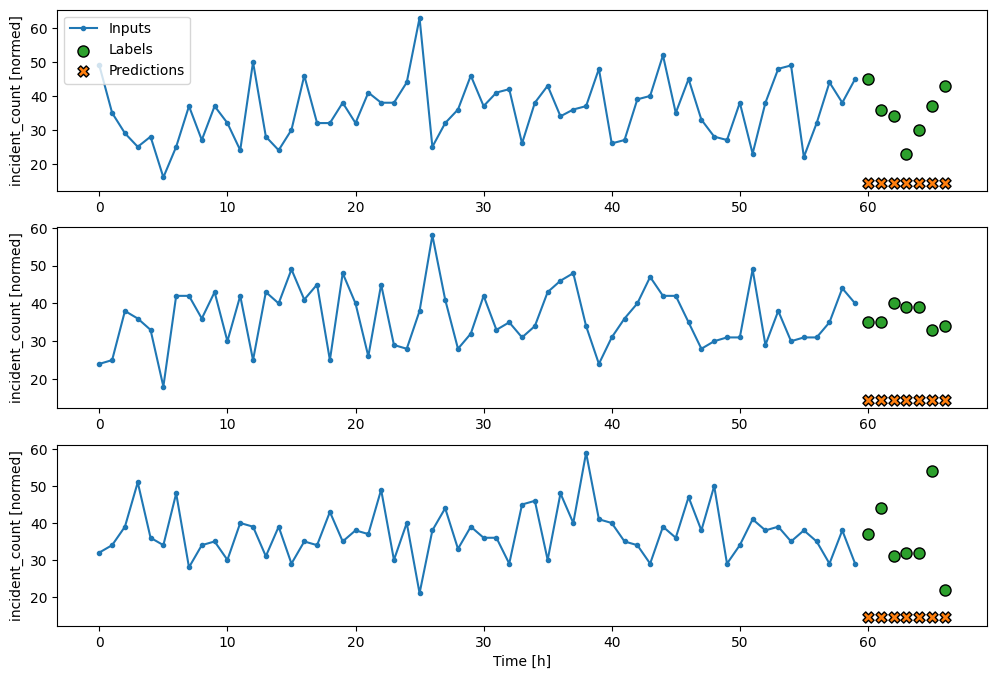

In [135]:
history = compile_and_fit(feedback_model, w)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(w.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(w.test, verbose=0, return_dict=True)
w.plot(feedback_model)

# Classifying incident categories
Are day of week/time/location good enough predictors?